Analysis of Plasmodium rebalancing in run10_11_v2. Based on experience from same samples in run10_11, the following conditions were used:

- six panel variants 80x P1/10x P2 `8010`; 80x P1/5x P2 `805`; anopheles only `ano`; plasmodium only `plas`; falciparum GRC1 `grc1`; falciparum GRC2 `grc2`
- two feed experiments with infection rate estimated as 60% (f15) and 94% (f16)
- two to three sampling points during high (day 1, blood stage parasites still present) and low (days 8-14, oocysts/sporozoites only left) expected infection intensities - 16 mosquito individuals per sampling point
- two rounds of DNA extraction from the same individuals: e1 - non-destructive, e2 - grinding with beads




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
READS = '../../../data/phylo_ampl_dada2/run10_11_v2/dada2/output/stats.tsv'
HAPS = '../../../data/phylo_ampl_dada2/run10_11_v2/dada2/output/haplotypes.tsv'

## Data prep

In [3]:
reads = pd.read_csv(READS, sep='\t')
reads.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
2835,8010_e1_f15_8d5,26,184,184,184,184,184,184,184


In [4]:
# mean read counts across mosquito targets
mean_mosq = reads[~reads.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq['target'] = 'M_avg'
mean_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
526,ano_e2_f16_9d2,23.0,22.580645,21.387097,21.354839,20.741935,20.741935,19.870968,M_avg


In [5]:
# mean read counts across mosquito targets
sum_mosq = reads[~reads.target.str.startswith('P')].groupby('s_Sample').sum().reset_index()
sum_mosq['target'] = 'M_sum'
sum_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
105,8010_e2_f15_14d8,3747,3708,3499,3506,3414,3414,3380,M_sum


In [6]:
# subset to plasmodium targets only
display(reads.shape)
reads = reads[reads.target.str.startswith('P')]
display(reads.shape)

(68352, 9)

(2136, 9)

In [7]:
# add averaged mosquito targets
display(reads.shape)
reads = pd.concat([reads, mean_mosq, sum_mosq], sort=True)
display(reads.shape)

(2136, 9)

(4272, 9)

In [8]:
# logscale input and output reads for plotting
reads['log_input'] = np.log10(reads['input'].replace(0,0.1))
reads['log_final'] = np.log10(reads['final'].replace(0,0.1))

## Blanks

In [9]:
# read counts in blanks - only for mosquito-plasmodium mixes
reads['blank'] = 'no'
reads.loc[reads.s_Sample.str.contains('blank'), 'blank'] = 'yes'

# low read counts as expected

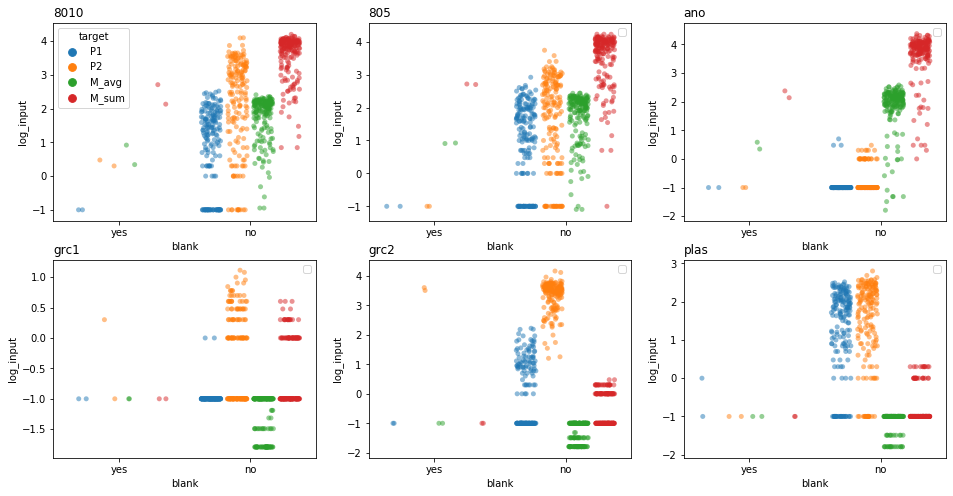

In [10]:
fig, axs = plt.subplots(2,3, figsize=(16, 8))
for panel, ax in zip(['8010', '805', 'ano', 'grc1', 'grc2', 'plas'],
                     axs.flatten()):
    sns.stripplot(data=reads[reads.s_Sample.str.startswith(panel)],
                   x='blank', 
                   y='log_input',
                   hue='target',
                   dodge=True,
                   jitter=.3,
                   alpha=.5,
                   ax=ax);
    ax.set_title(panel, loc='left')
    # legend only in first subplot
    if panel!='8010':
        ax.legend([])

In [11]:
# discard blanks
reads = reads[reads['blank'] == 'no']
reads.shape

(4224, 12)

In [12]:
# parse sequence names
def parse_sequence_names(reads):
    p = reads.s_Sample.str.split('_', expand=True)
    reads['panel'] = p[0]
    reads['extraction'] = p[1]
    reads['feed'] = p[2]
    # parse day and indivudual
    di = p[3].str.split('d', expand=True)
    reads['day'] = di[0]
    reads['indivudual'] = di[1]
    # handle uninfected
    u = reads['day'].str.startswith('un')
    reads.loc[u, 'indivudual'] = reads.loc[u, 'day'].str.slice(start=2)
    reads.loc[u, 'day'] = 'un'
    # handle day sorting
    sdd = reads.day.str.len() == 1
    reads.loc[sdd, 'day'] = '0' + reads.loc[sdd, 'day']
    # sampling points - combination of feed and day
    reads['sampling_point'] = reads.feed + '_' + reads.day
    reads['sampling_point'] = reads['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
    
    return reads
reads = parse_sequence_names(reads)
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final,blank,panel,extraction,feed,day,indivudual,sampling_point
1006,1.0,1.0,1.0,0.0,1.0,0.0,0.0,plas_e2_f15_1d4,M_sum,0.0,-1.0,no,plas,e2,f15,01,4,f15_01


In [13]:
reads.day.unique()

array(['13', '14', '01', '08', 'un', '09'], dtype=object)

In [14]:
reads.panel.unique()

array(['8010', '805', 'ano', 'grc1', 'grc2', 'plas'], dtype=object)

## P2 concentration effects

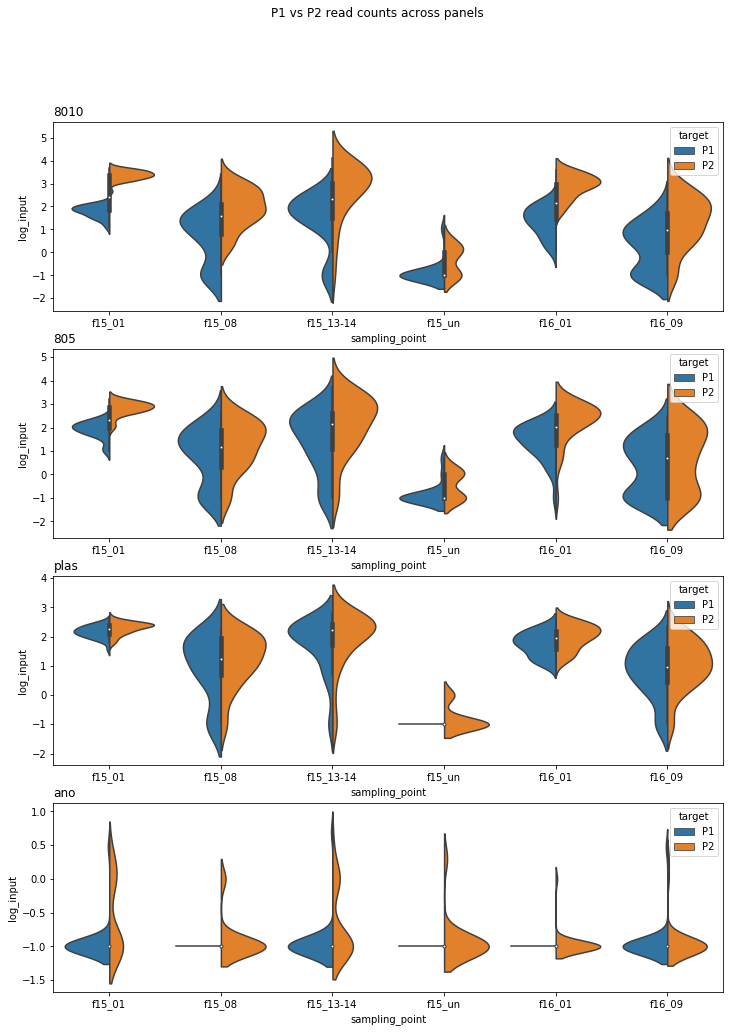

In [15]:
fig, axs = plt.subplots(4,1, figsize=(12, 16))
for panel, ax in zip(['8010','805','plas','ano'], axs.flatten()):
    sns.violinplot(data=reads[(reads.panel == panel) & 
                              (reads.target.str.startswith('P'))] \
                             .sort_values('sampling_point'), 
                   x="sampling_point", 
                   y="log_input", 
                   hue="target", split=True, ax=ax)
    ax.set_title(panel, loc='left')
fig.suptitle('P1 vs P2 read counts across panels');

Plasmodium primer imbalance is better for 80/5, still significant difference. For pure plasmodium speciation, balance is much better.

In [16]:
# alternative visualisation, not so informative, but shows no changes in mosquito read counts between 80/10 & 80/5

# # total number of reads per day 
# fig, axs = plt.subplots(3,1, figsize=(12, 12))
# for tgt, ax in zip(['P1','P2','M_avg'], axs.flatten()):
#     sns.violinplot(data=reads[reads.panel.str.startswith('8') & (reads.target == tgt)], 
#                    x="sampling_point", 
#                    y="log_input", 
#                    hue="panel", split=True, ax=ax)
#     ax.set_title(tgt, loc='left')
# fig.suptitle('P2 concentration effect on read counts across amplicons');
# # same as input reads

## Extraction & feed effects

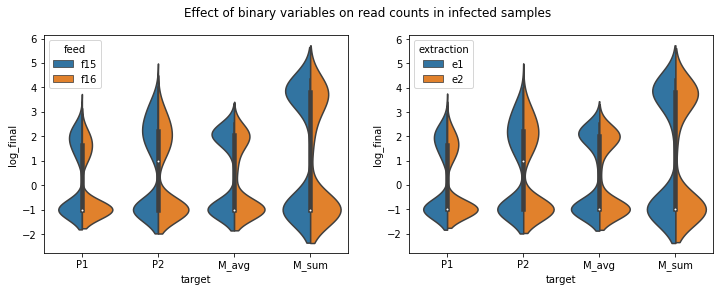

In [17]:
# read counts
fig, axs = plt.subplots(1,2, figsize=(12, 4))
for ax, col in zip(axs.flatten(), ['feed', 'extraction']):
    sns.violinplot(data=reads[reads.day != 'un'], 
                   x="target", y="log_final", hue=col, split=True, 
                   ax=ax)
fig.suptitle('Effect of binary variables on read counts in infected samples');
# ax.set_title('Extension temperature on infected samples');

In [18]:
# per-sample read counts (except plasmodium speciation panel)
pr = reads[~reads.panel.str.startswith('grc')].pivot('s_Sample','target', 'input').reset_index()
pr = parse_sequence_names(pr)
pr.sample()

target,s_Sample,M_avg,M_sum,P1,P2,panel,extraction,feed,day,indivudual,sampling_point
128,8010_e2_f15_8d2,119.629032,7417.0,0.0,11.0,8010,e2,f15,08,2,f15_08


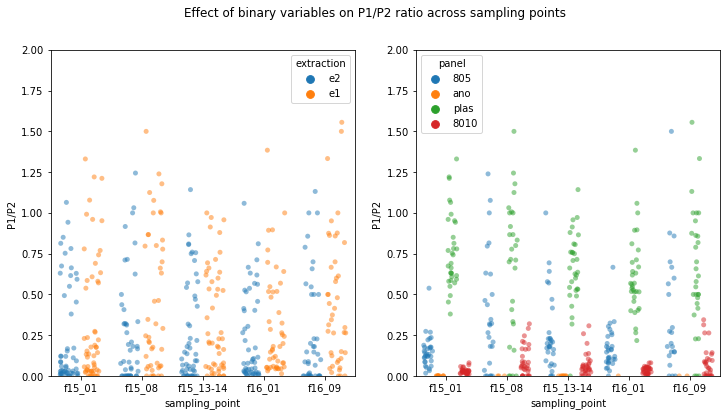

In [19]:
# explicit ratio plotting
pr['P1/P2'] = pr.P1 / pr.P2
d = pr[pr.day != 'un'].sort_values('sampling_point')
fig, axs = plt.subplots(1,2, figsize=(12, 6))
for ax, col in zip(axs, ['extraction', 'panel']):
    sns.stripplot(data = d, dodge=True, 
                x='sampling_point',y='P1/P2',
                hue=col,
                alpha=.5,
                jitter=.3,
                ax=ax)
    ax.set_ylim(0, 2);
fig.suptitle('Effect of binary variables on P1/P2 ratio across sampling points');

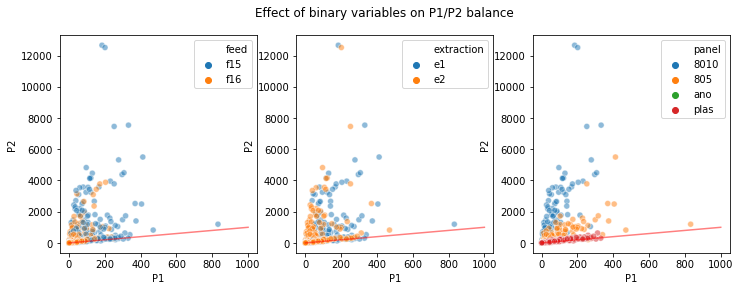

In [20]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for ax, col in zip(axs.flatten(), ['feed', 'extraction', 'panel']):
    sns.scatterplot(data=pr,
                x='P1',y='P2',
                hue=col,
                ax=ax,
                alpha=.5);
    ax.plot((0, 1000),(0, 1000), c='r', alpha=0.5)
fig.suptitle('Effect of binary variables on P1/P2 balance');

No effect of extraction on primer balance unlike previous attempt (run10_11). Can it be some mis-attribution in the previous run?

## P1/P2 linear regression

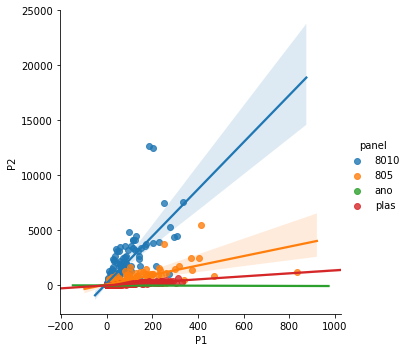

In [21]:
# linear regression - plot
sns.lmplot(data=pr,
            x='P1',y='P2',hue='panel');

In [22]:
# linear regression - numeric
for panel in pr.panel.unique():
    x = pr.loc[pr.panel==panel, 'P1']
    y = pr.loc[pr.panel==panel, 'P2']
    print(panel,'\n',linregress(x,y),'\n')

8010 
 LinregressResult(slope=21.391130576389024, intercept=196.05252662594035, rvalue=0.7568224302916761, pvalue=5.846500769513111e-34, stderr=1.4005248221028268) 

805 
 LinregressResult(slope=4.285327833675967, intercept=100.10659709722773, rvalue=0.7033573797377654, pvalue=1.378165743441382e-27, stderr=0.3283243110006176) 

ano 
 LinregressResult(slope=-0.05317577548005929, intercept=0.20786894051295826, rvalue=-0.05065074471147906, pvalue=0.5043898156139524, stderr=0.07948690117497002) 

plas 
 LinregressResult(slope=1.3637747944447234, intercept=9.557055441959903, rvalue=0.9326079611848381, pvalue=6.229151291905396e-79, stderr=0.04000783925509147) 



In [23]:
# linear regression - numeric for e1 only
for panel in pr.panel.unique():
    x = pr.loc[(pr.panel==panel) & (pr.extraction == 'e1'), 'P1']
    y = pr.loc[(pr.panel==panel) & (pr.extraction == 'e1'), 'P2']
    print(panel,'\n',linregress(x,y),'\n')

8010 
 LinregressResult(slope=18.351327807450932, intercept=183.04063185103269, rvalue=0.7418856785607948, pvalue=1.351800337192819e-16, stderr=1.7885338132809814) 

805 
 LinregressResult(slope=3.984479322302971, intercept=80.22264942688321, rvalue=0.6923923183798669, pvalue=7.893921981087945e-14, stderr=0.44773312022705863) 

ano 
 LinregressResult(slope=-0.032786885245901516, intercept=0.13934426229508196, rvalue=-0.04990133448348878, pvalue=0.6442888736509882, stderr=0.07076155581746518) 

plas 
 LinregressResult(slope=1.2948445573218847, intercept=10.350377619767784, rvalue=0.9176844060588308, pvalue=3.125810031648651e-36, stderr=0.06045116634098816) 



21x performance difference between P1 and P2 in `8010`, 4x - in `805`, 1.3x - in `plas`. Correlation coefficients increase getting closer to same performance. 

## Same-sample correlations between extractions and panels

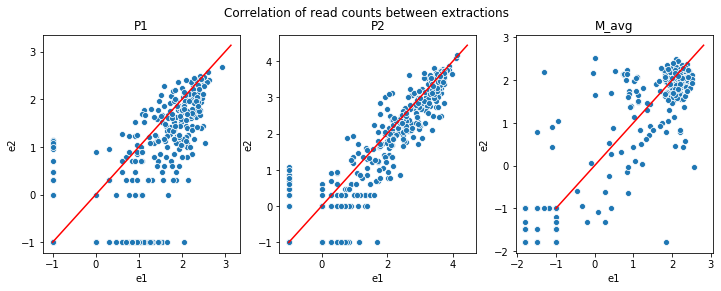

In [24]:
reads['sample_no_extraction'] = reads.panel + '_' + reads.feed + '_' + reads.day + '_' + reads.indivudual
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='extraction',
                   index='sample_no_extraction',
                   values='log_input')
    sns.scatterplot(data=d,
                x='e1',y='e2',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between extractions');


Higher plasmodium efficiency in e1, mosquito correlations are harder to trace.

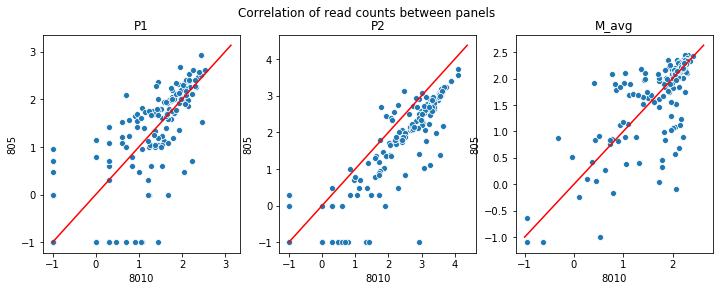

In [25]:
reads['sample_no_panel'] = reads.extraction + '_' + reads.feed + '_' + reads.day + '_' + reads.indivudual
def plot_panel_corr(reads, panel1, panel2):
    fig, axs = plt.subplots(1,3, figsize=(12, 4))
    for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
        d = reads[reads.target == target] \
                .pivot(columns='panel',
                       index='sample_no_panel',
                       values='log_input')
        sns.scatterplot(data=d,
                    x=panel1,y=panel2,
                    ax=ax)
        plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot((-1, plt_max),(-1, plt_max), c='r')
        ax.set_title(target)
    fig.suptitle('Correlation of read counts between panels');
plot_panel_corr(reads, '8010', '805')

`805` vs `8010`. Reduction in P2 counts as expected, reduction of mosquito read counts is worrying. 

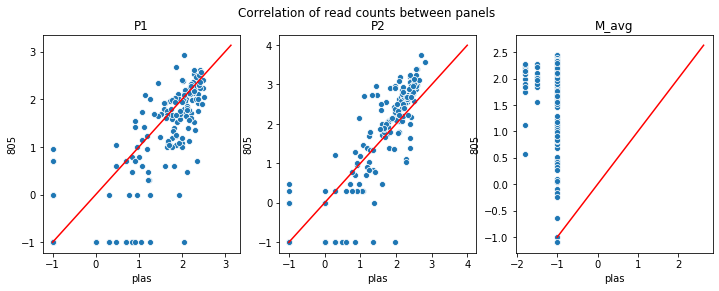

In [26]:
plot_panel_corr(reads, 'plas', '805')

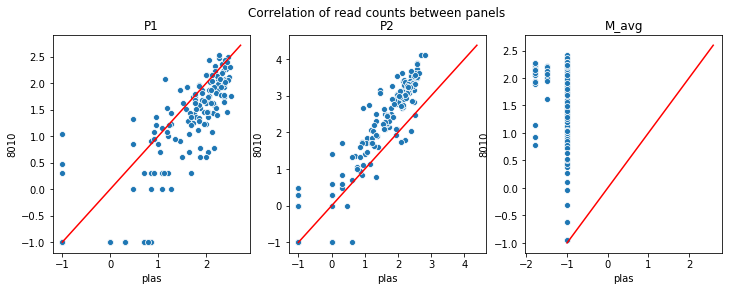

In [27]:
plot_panel_corr(reads, 'plas', '8010')

Higher efficiency of P1 in `plas`, lower efficiency and higher correlation of P2 in `plas` -  compared to both `8010` and `805`

## infection inference

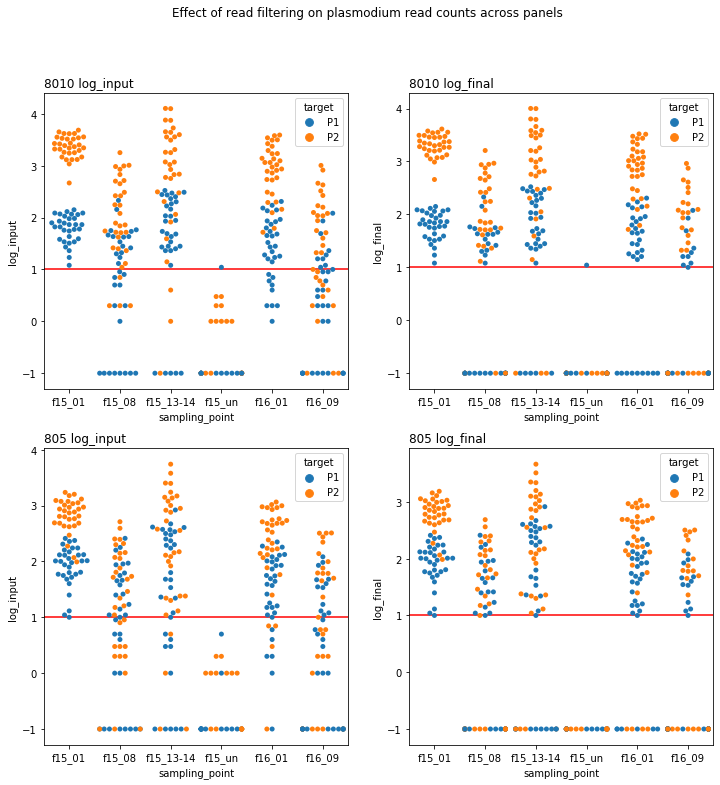

In [28]:
# compare two P2 concentration panels
fig, axs = plt.subplots(2,2,figsize=(12,12))
for panel, subaxs in zip(['8010','805'], axs):
    for col, ax in zip(['log_input','log_final'], subaxs):
        ds = reads[(reads.panel == panel)
          & reads.target.str.startswith('P')].sort_values('sampling_point')
        sns.swarmplot(data=ds,
                      x='sampling_point',
                      y=col,
                      hue='target',
                      ax=ax)
        ax.axhline(1, c='r');
        ax.set_title('{} {}'.format(panel, col), loc='left');
fig.suptitle('Effect of read filtering on plasmodium read counts across panels');

Cutoff of 10 reads is currently used by DADA2 and works indeally for `805` and almost ideally for `8010`. A bunch of low-level infections appear in f16_01 (that had lower infection rate in previous run, but not that low). 

In [29]:
infd = reads[(reads.panel == '8010')
      & reads.target.str.startswith('P') 
      & (reads.extraction == 'e1')].copy()
infd['infected'] = infd['log_final'] > 0
pd.crosstab(infd.sampling_point, infd.infected)

infected,False,True
sampling_point,,
f15_01,0,32
f15_08,7,25
f15_13-14,3,29
f15_un,16,0
f16_01,2,30
f16_09,14,18


In [30]:
infd = reads[(reads.panel == '805')
      & reads.target.str.startswith('P') 
      & (reads.extraction == 'e1')].copy()
infd['infected'] = infd['log_final'] > 0
pd.crosstab(infd.sampling_point, infd.infected)

infected,False,True
sampling_point,,
f15_01,0,32
f15_08,10,22
f15_13-14,6,26
f15_un,16,0
f16_01,4,28
f16_09,16,16


In [31]:
# subset & sort reads
reads['specimen'] = reads.feed + '_' + reads.day + '_' + reads.indivudual
ds = reads[reads.target.str.startswith('P') &
           reads.panel.isin(['8010','805','plas'])].sort_values('sampling_point')
# infection inference 
ds['infected'] = False
ds.loc[ds.log_final >= 1, 'infected'] = True

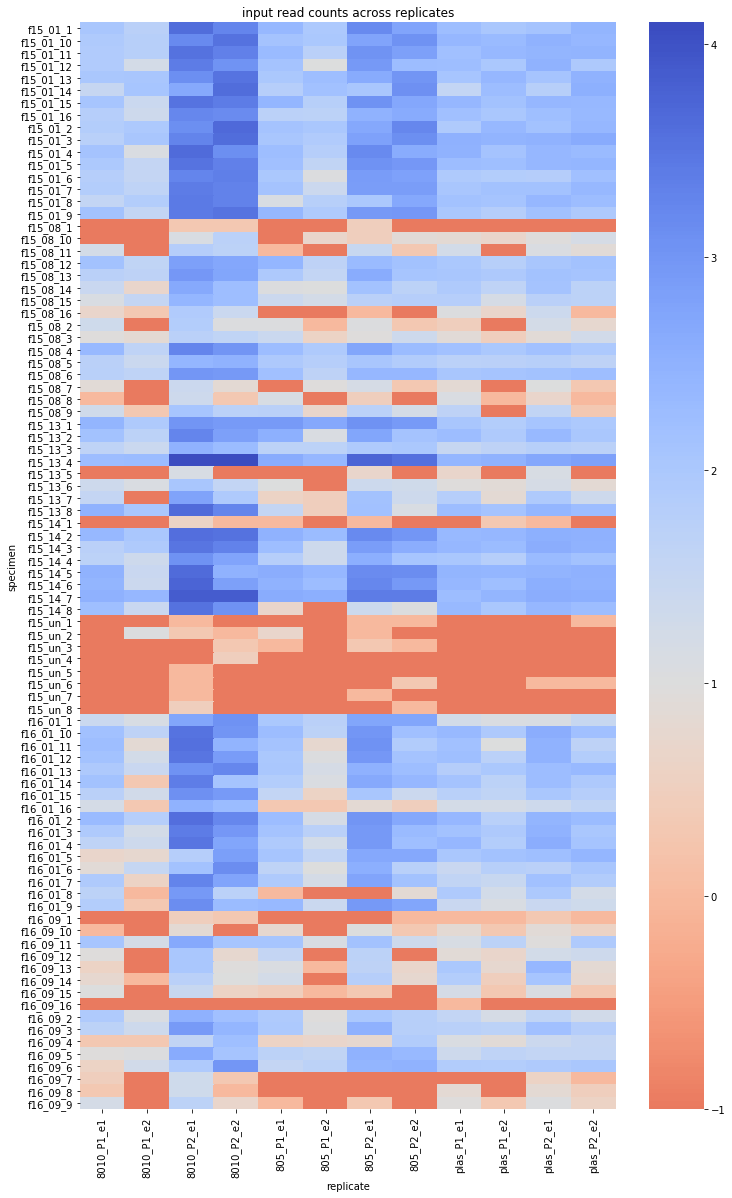

In [32]:
# all-sample exploration
ds['replicate'] = ds.panel + '_' + ds.target + '_' + ds.extraction 
fig, ax = plt.subplots(1,1,figsize=(12,20))
sns.heatmap(
    ds.pivot('specimen','replicate','log_input'),
    cmap='coolwarm_r',
    center=1,
    ax=ax
);
plt.title('input read counts across replicates');

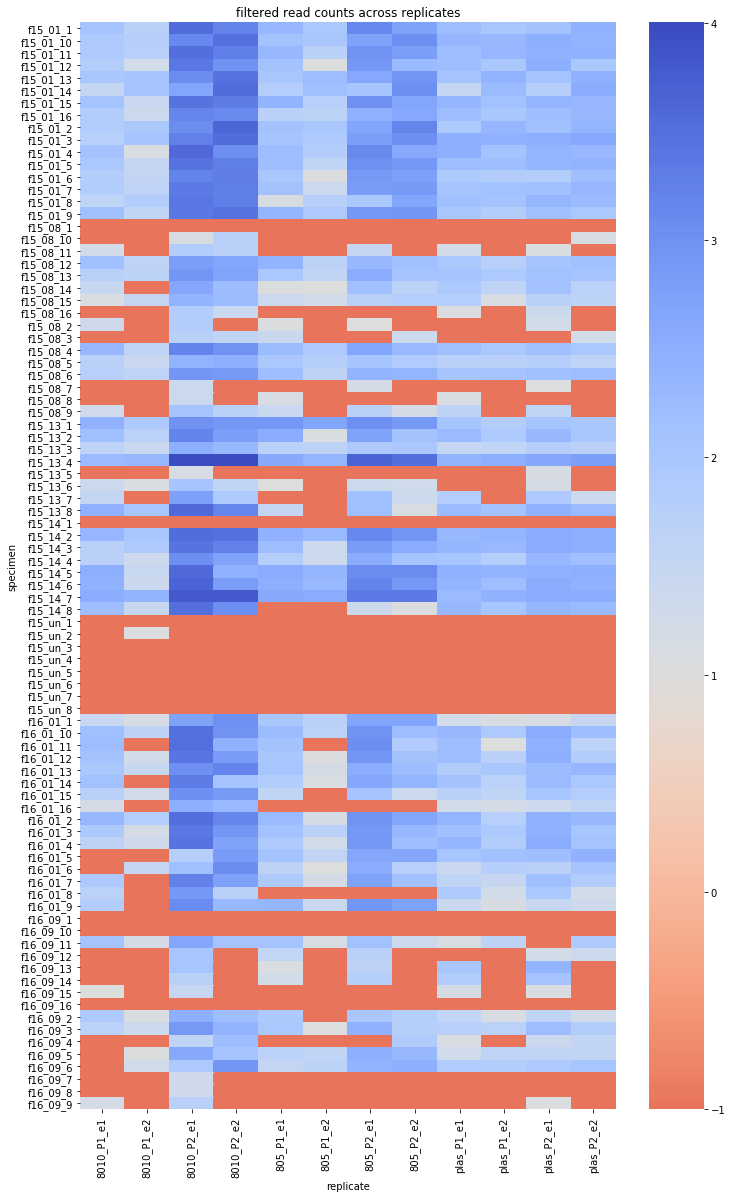

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12,20))
sns.heatmap(
    ds.pivot('specimen','replicate','log_final'), 
    cmap='coolwarm_r',
    center=1,
    ax=ax
);
plt.title('filtered read counts across replicates');

## Infection inference disagreements

In [34]:
# group specimen by parameter
inf_per_panel = ds.groupby(['specimen','panel'])['infected'].sum().unstack().astype(int)
inf_per_tgt = ds.groupby(['specimen','target'])['infected'].sum().unstack().astype(int)
inf_per_extraction = ds.groupby(['specimen','extraction'])['infected'].sum().unstack().astype(int)
# mask - keep only inconsistent samples
mask = ~inf_per_panel.isin([0,4]).all(axis=1) & \
       ~inf_per_tgt.isin([0,6]).all(axis=1) & \
       ~inf_per_extraction.isin([0,6]).all(axis=1)

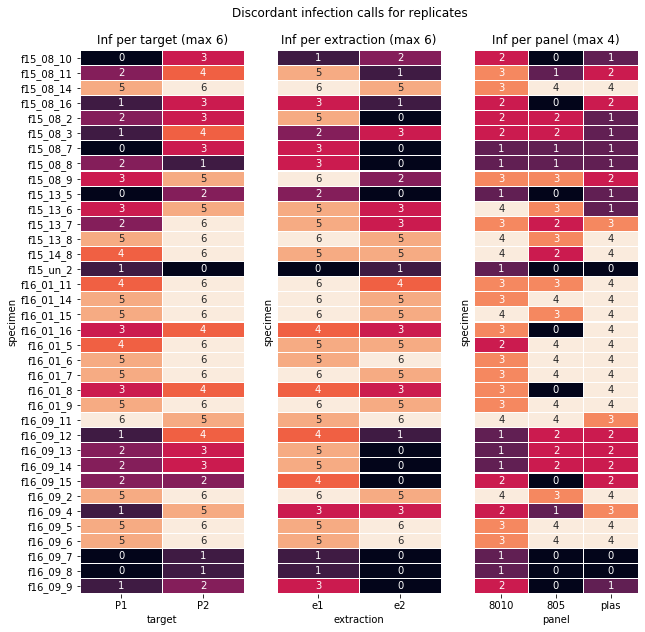

In [35]:
# plt effects 
fig, axs = plt.subplots(1,3,figsize=(10,10))
for d, title, ax in zip([inf_per_tgt, inf_per_extraction, inf_per_panel],
                        ['target','extraction','panel'],
                        axs):
    max_value = d.max().max()
    sns.heatmap(
        d.loc[mask],
        cbar=False, 
        annot=True,
        linewidths=.1,
        yticklabels = True if title=='target' else False,
        ax=ax
    )
    ax.set_title('Inf per {} (max {})'.format(title, max_value));
fig.suptitle('Discordant infection calls for replicates', y=0.94);

Occaisional dropouts for `805` at day 1: f16_01_16 & f16_01_08 - same samples behaved differently in run10_11. No complete dropouts though. Same for f16_09_15.

In [36]:
ds.specimen.value_counts()

f15_08_16    12
f15_13_7     12
f16_09_16    12
f16_09_12    12
f16_09_4     12
             ..
f15_08_1     12
f15_01_16    12
f15_14_2     12
f16_09_15    12
f15_08_3     12
Name: specimen, Length: 88, dtype: int64

## Replicate comparison with previous run

Code for loading sample data is copied with modifications from 78_run10_11 notebook

In [37]:
READS_OLD = '../../../data/phylo_ampl_dada2/run10_11/dada2/output/stats.tsv'
HAPS_OLD = '../../../data/phylo_ampl_dada2/run10_11/dada2/output/haplotypes.tsv'

In [38]:
reads_old = pd.read_csv(READS_OLD, sep='\t')
# do not keep mosquito data
reads_old = reads_old[reads_old.target.str.startswith('P')]
# remove blanks
reads_old = reads_old[~reads_old.s_Sample.str.contains('blank')]
reads_old.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
21118,e1_f16_9d3_51s,P1,9619,9608,9608,9608,9608,9608,9608


In [39]:
# parse read names
p = reads_old.s_Sample.str.split('_', expand=True)
reads_old['extraction'] = p[0]
reads_old['feed'] = p[1]
# parse day and specimen
di = p[2].str.split('d', expand=True)
reads_old['day'] = di[0]
reads_old['individual'] = di[1]
# handle uninfected
u = reads_old['day'].str.startswith('un')
reads_old.loc[u, 'individual'] = reads_old.loc[u, 'day'].str.slice(start=2)
reads_old.loc[u, 'day'] = 'un'
# handle day sorting
sdd = reads_old.day.str.len() == 1
reads_old.loc[sdd, 'day'] = '0' + reads_old.loc[sdd, 'day']
# sampling points - combination of feed and day
reads_old['sampling_point'] = reads_old.feed + '_' + reads_old.day
reads_old['sampling_point'] = reads_old['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
# parse temp and cycling
reads_old['extension_temp'] = p[3].str.slice(stop=-1) + 'C'
reads_old['cycling'] = p[3].str.get(-1).replace({'s':'subcycling','c':'standard'})
reads_old.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final,extraction,feed,day,individual,sampling_point,extension_temp,cycling
37183,e2_f15_un8_51c,P2,20,20,20,20,20,20,20,e2,f15,un,8,f15_un,51C,standard


In [40]:
# logscale input and output reads for plotting
reads_old['log_input'] = np.log10(reads_old['input'].replace(0,0.1))
reads_old['log_final'] = np.log10(reads_old['final'].replace(0,0.1))
# set up specimen and replicate
reads_old['specimen'] = reads_old.feed + '_' + reads_old.day + '_' + reads_old.individual
reads_old['replicate'] = 'r8020_' + reads_old.cycling + '_' + reads_old.extension_temp + '_' +reads_old.target + '_' +  reads_old.extraction 

In [41]:
# combine data
comb_reads = pd.concat([ds, reads_old], sort=False)

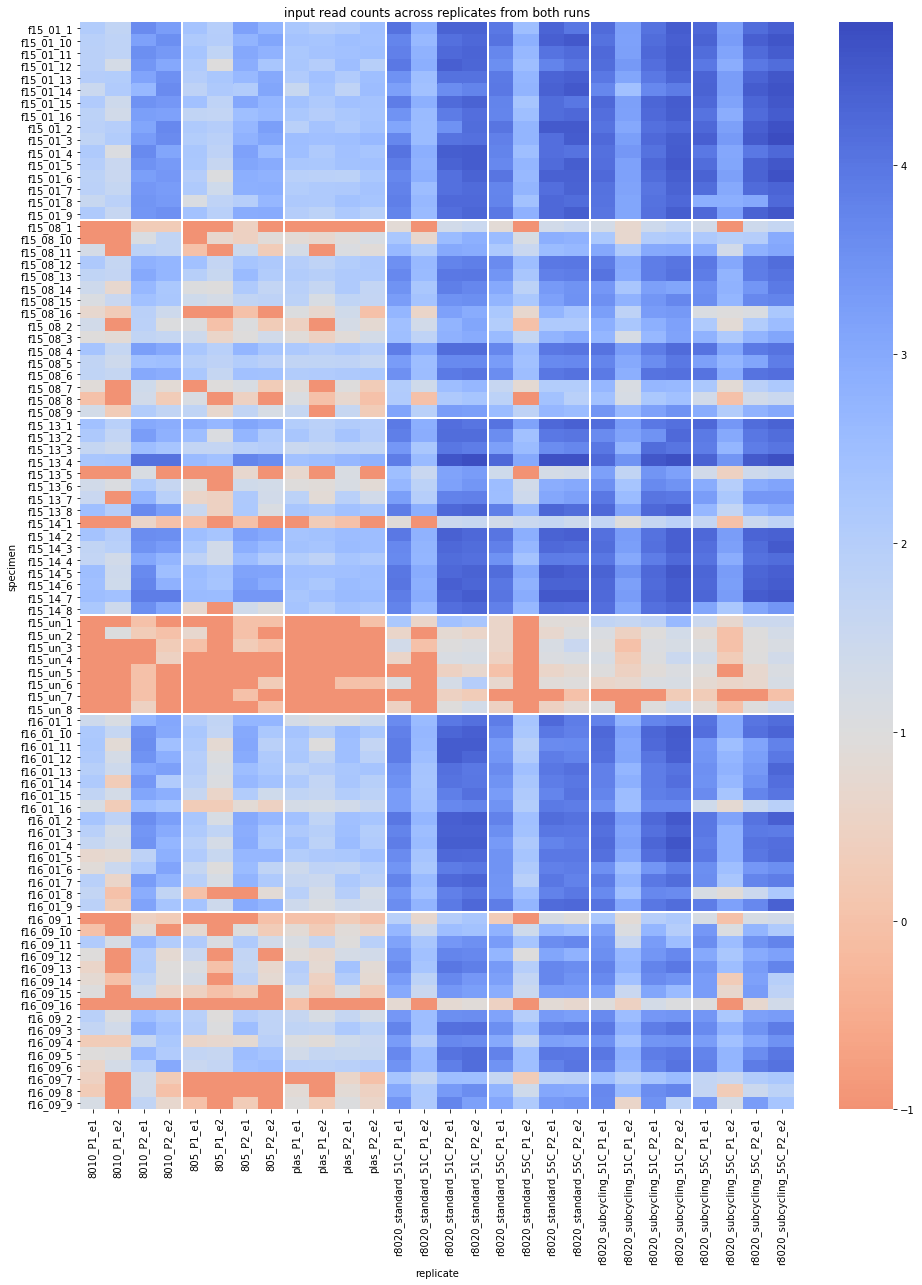

In [42]:
fig, ax = plt.subplots(1,1,figsize=(16,20))
sns.heatmap(
    comb_reads.pivot('specimen','replicate','log_input'),
    cmap='coolwarm_r',
    center=1,
    ax=ax
);
# grid
for x in range(6):
    ax.axvline(4 * (x + 1), linewidth=2, c='w')
for x in (2,4,6,7,9):
    ax.axhline(8 * x, linewidth=2, c='w')
plt.title('input read counts across replicates from both runs');

Overall correlation between samples (rows) is obvious. Both `8010` and `805` yield meaningful calls for uninfected samples. When compared to `8020` series of replicates, decrease in read counts is significant for both P1 (which was not altered) and P2. 

Samples with unstable yield in `805`, e.g. f16_01_08/16 have problems with amplification in previous run. 